In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
waterDF = pd.read_csv('data/total_water_quantity_measurement.csv', encoding='euc-kr')

# 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce') # errors='coerce' /-. 이 아니면 none 타입으로 변환된다.

waterDF

,총량지점명,일자,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s)
0,낙본L,2020-12-02,11.0,8.3,316,11.7,1.1,5.0,2.4,2.516,0.028,3.4,47.960
1,낙본M,2020-12-04,9.7,7.7,441,11.1,1.3,5.0,5.2,2.263,0.024,3.3,185.830
2,낙본N,2020-12-04,6.8,7.5,388,11.8,1.3,5.4,11.6,2.955,0.056,3.8,28.922
3,낙본L,2020-12-07,9.5,7.6,331,11.1,0.8,4.7,0.4,2.953,0.024,3.6,81.440
4,낙본M,2020-12-09,8.9,7.3,357,11.1,0.9,4.8,3.6,2.370,0.024,3.6,179.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,낙본M,2025-10-21,20.6,7.8,257,8.5,1.3,6.2,10.0,2.663,0.069,4.7,365.147
549,낙본N,2025-10-21,19.7,7.5,940,8.2,2.5,9.3,10.4,2.489,0.047,7.4,0.000
550,낙본L,2025-10-27,19.0,7.8,192,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180
551,낙본M,2025-10-27,19.3,8.2,272,9.7,1.4,7.0,8.4,2.661,0.080,3.9,208.869


### 기본 녹조 분석
1. 언제 녹조가 심해지는가? (시기성)
2. 어떤 수질 요인이 녹조와 가장 관련 있는가?
3. 유량 변화가 녹조를 악화/완화하는가?
4. 질소·인의 역할은 어느 쪽이 더 큰가?
5. 임계 조건(Threshold)이 있는가?

In [4]:
waterDF.select_dtypes(include='number').describe()

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s)
count,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.00000,553.000000,553.000000,553.000000
mean,17.873779,7.955154,519.846293,10.260579,2.347920,6.816275,9.903978,2.51045,0.050678,4.533092,209.826839
std,7.991181,0.516832,356.326171,2.249187,1.241507,1.918500,6.455414,0.69266,0.025995,1.327103,439.611497
min,1.500000,6.500000,118.000000,6.000000,0.400000,3.900000,0.300000,0.84800,0.016000,2.100000,0.000000
25%,11.100000,7.600000,277.000000,8.500000,1.500000,5.600000,5.200000,2.03600,0.031000,3.600000,7.766000
50%,18.800000,7.900000,417.000000,9.700000,2.000000,6.400000,8.400000,2.48700,0.044000,4.300000,89.020000
75%,25.100000,8.400000,674.000000,11.700000,2.900000,7.400000,13.200000,2.98700,0.065000,5.000000,217.617000
max,32.000000,9.200000,3458.000000,16.000000,8.500000,18.900000,43.200000,5.41400,0.194000,12.900000,4962.290000


In [9]:
wd = waterDF.select_dtypes(include='number').corr()
wd

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s)
수온(℃),1.000000,0.135735,-0.193504,-0.843219,-0.018756,0.352023,0.252541,-0.667374,0.292377,0.241075,0.263255
수소이온농도(ph),0.135735,1.000000,0.122654,0.189415,0.376148,0.350836,0.019091,-0.262423,-0.295988,0.293707,-0.291475
전기전도도(μS/㎝),-0.193504,0.122654,1.000000,0.137874,0.435484,0.476786,0.307818,0.183031,0.149659,0.451463,-0.335655
용존산소(㎎/L),-0.843219,0.189415,0.137874,1.000000,0.228951,-0.165583,-0.248069,0.513941,-0.388570,-0.091310,-0.287389
BOD(㎎/L),-0.018756,0.376148,0.435484,0.228951,1.000000,0.751004,0.534037,0.101919,0.286564,0.714796,-0.192209
COD(㎎/L),0.352023,0.350836,0.476786,-0.165583,0.751004,1.000000,0.629656,-0.220550,0.449970,0.878722,-0.112248
부유물질(㎎/L),0.252541,0.019091,0.307818,-0.248069,0.534037,0.629656,1.000000,-0.099586,0.635024,0.578280,0.128429
총질소(T-N)(㎎/L),-0.667374,-0.262423,0.183031,0.513941,0.101919,-0.220550,-0.099586,1.000000,0.020645,-0.068691,-0.148664
총인(T-P)(㎎/L),0.292377,-0.295988,0.149659,-0.388570,0.286564,0.449970,0.635024,0.020645,1.000000,0.409250,0.182322
총유기탄소(TOC)(㎎/L),0.241075,0.293707,0.451463,-0.091310,0.714796,0.878722,0.578280,-0.068691,0.409250,1.000000,-0.120972


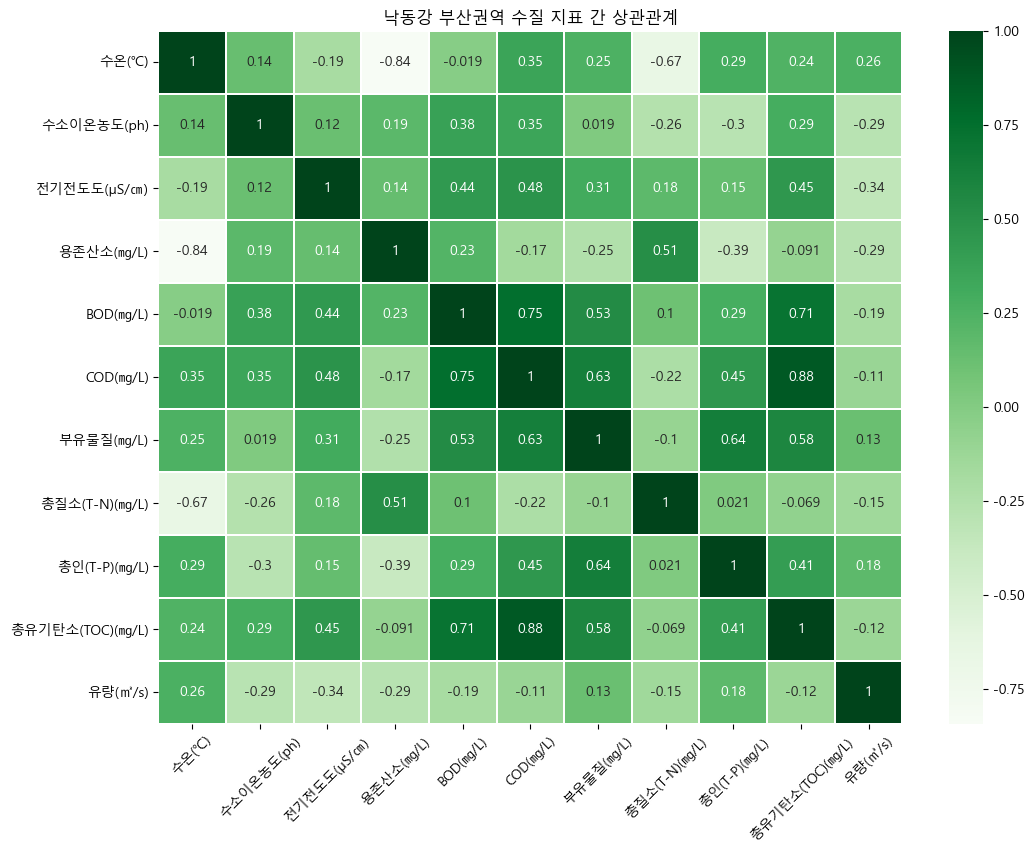

In [36]:
plt.figure(figsize=(12, 9))
plt.title('낙동강 부산권역 수질 지표 간 상관관계')
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=45)
plt.show()